In [14]:
import os
import jax
import tax
import rlax
import tqdm
import haiku as hk
import numpy as np
import collections 
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
import typing
import optax
import chex
import tree
import mbrl

from jax import jit
from jax import partial
from mbrl.envs.oracle._pendulum import env_params, render
from mbrl.envs.oracle._pendulum import reset_fn, step_fn
from mbrl.envs.oracle._pendulum import reward_fn

os.environ['JAX_CHECK_TRACER_LEAKS'] = '1'
tax.set_platform('gpu')
Environment = collections.namedtuple('Environment', ['step', 'reset']) 
rng = jax.random.PRNGKey(42)

# -- Setup the Environment
step_fn = jit(partial(step_fn, env_params=env_params))
reset_fn = jit(partial(reset_fn, env_params=env_params))
env = Environment(step=step_fn, reset=reset_fn)

TARGET_LEARNING = 'observation'

In [15]:
from train_fmodel import init_fmodel_training

In [16]:
action_size = env_params.get('action_size')

if TARGET_LEARNING == 'observation':
    observation_size = len(env.reset(rng)[-1])
else:
    observation_size = 2

rb = tax.ReplayBuffer(100_000)

# `Setup` Training Loop

In [35]:
rng, subrng = jax.random.split(rng)

"""
state, fit = init_fmodel_training(
    rng, observation_size, action_size, 'D', 
    {'hidden_sizes': [32, 32], 'final_tanh_activation': False}, 
    'adabelief', {'learning_rate': 5e-3},
    fmodel_training_kwargs={'use_norm': False, 'use_residual': True ,'early_stopping_patience': 50, 'max_epochs': 50}
)
"""


state, fit = init_fmodel_training(
    rng, observation_size, action_size, 'P', 
    {'hidden_sizes': [32, 32], }, 
    'adabelief', {'learning_rate': 1e-3},
    fmodel_training_kwargs={'use_norm': True, 'use_residual': True ,'early_stopping_patience': 50, 'max_epochs': 500}
)


# `Initialization` with Random Interaction

In [36]:
# TODO: Random Interaction depends of Discrete Environment / Continuous 
buf = []
for _ in range(10):
    score = 0
    env_state, observation = env.reset(rng)
    for _ in range(200):
        rng, key = jax.random.split(rng)
        action = jax.random.uniform(key, (1,), minval=-2., maxval=2.)
        env_state_next, observation_next, reward, terminal, info = env.step(env_state, action)
        score += reward
        buf.append({
            'observation': observation,
            'observation_next': observation_next,
            'action': action,
            #'reward': reward,
            'env_state': env_state,
            'env_state_next': env_state_next
        })
        observation = observation_next.copy()
        env_state = env_state_next
    print(f'Random Score: {score}')
    
data = tax.reduce(buf)
rb.add(**data)


Random Score: -1767.124267578125
Random Score: -1464.91162109375
Random Score: -1599.35009765625
Random Score: -1697.143310546875
Random Score: -1257.904541015625
Random Score: -1445.5078125
Random Score: -1061.43603515625
Random Score: -1064.2076416015625
Random Score: -1067.654541015625
Random Score: -1072.249267578125


In [37]:
data = rb.dataset()
buf = {
    'observation': data['env_state'],
    'observation_next': data['env_state_next'],
    'action': data['action']
}

buf = {
    'observation': data['observation'],
    'observation_next': data['observation_next'],
    'action': data['action']
}



state, fmodel_inference, info = fit(buf, state)

100%|██████████| 500/500 [01:24<00:00,  5.92it/s, loss/train=-12.9, loss/valid=-13]  


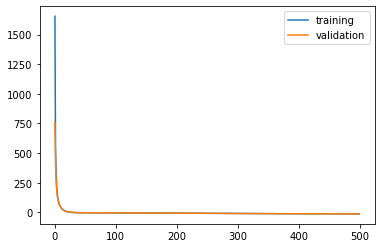

In [41]:
plt.plot(info['loss/train'], label='training')
plt.plot(info['loss/valid'], label='validation')
plt.legend()

In [42]:
X = buf['observation'][0]
A = buf['action'][0]
print(fmodel_inference(rng, X, A))
Y = buf['observation_next'][0]
print(Y)

[0.77198863 0.63500005 0.27660456]
[0.77210432 0.63549584 0.26341721]


In [43]:
from mbrl.algs.rs import trajectory_search, forecast, score, plan

In [44]:
# NOTE: Terminal=False is not possible
# --> partial world with reward and terminal function
# --> if not provided set terminal to false.
# NOTE: GT Model to compare and anylyse the planning model.
# NOTE (%) = The state is ignore.
# NOTE = Reward function [observation_next/observation]
@jit
def world(carry, t):
    keys, (state, observation), trajectory = carry
    
    key = keys[t]
    action = trajectory[t]
    
    # -- Forward Model
    observation_next = fmodel_inference(key, observation, action)
    reward = reward_fn(observation, action)
    # -- Ground Truth (reward/observation from model)
    #observation_next, observation_next, reward, terminal, info = env.step(state, action)
    
    carry = keys, (state, observation_next), trajectory
    return carry, {
        'key': key,
        "observation": observation,
        "observation_next": observation_next,
        "reward": reward, 
        "action": action, 
        #"terminal": 1. - terminal,
        #"state": state,
        #"state_next": state_next,
    }

In [45]:
score_ = partial(score, terminal_reward_fn = None, discount = 0.99)
forecast_ = partial(
    forecast, 
    step_fn=world, 
    horizon=20, 
    action_type =env_params.get('action_type', 'continuous'),
    action_dim=action_size, 
    minval=env_params.get('action_min'), 
    maxval=env_params.get('action_max')
)


policy = partial(plan, forecast=forecast_, score=score_, population=2000)
policy = jit(policy)

In [46]:
x = env.reset(rng)
out = forecast_(rng, x)

In [47]:
hk.data_structures.to_immutable_dict

<function haiku._src.data_structures.to_immutable_dict(mapping: Mapping[~K, ~V]) -> Mapping[~K, ~V]>

In [48]:
""" Entire Loop with scan"""

@jit
def one_step(carry, t):
    key, (env_state, observation)  = carry
    key, subkey = jax.random.split(key)
    action, action_info = policy(subkey, (env_state, observation))
    action = action[0]
    env_state_next, observation_next, reward, terminal, info = \
        env.step(env_state, action)
    carry = key, (env_state_next, observation_next)
    return carry, {
        "observation": observation,
        "observation_next": observation_next,
        "reward": reward, "action": action, "terminal": 1 - terminal,
        "env_state": env_state, 
        'env_state_next': env_state_next,
        "action_info": action_info,
    }

In [49]:
%%time
for _ in range(10):
    rng, subrng = jax.random.split(rng)
    env_state, observation = env.reset(subrng)
    init = (rng, (env_state, observation))
    _, out = jax.lax.scan(one_step, init, jnp.arange(200))
    print(jnp.sum(out['reward']))
    action = out['action']
    env_state = out['env_state']
    env_state_next = out['env_state_next']
    
    rb.add(action=action, env_state=env_state, env_state_next=env_state_next)

-120.83589
-243.69693
-119.84743
-126.11625
-359.26944
-124.13426
-125.82528
-0.7477482
-125.43945
-126.00394
CPU times: user 2.99 s, sys: 33.8 ms, total: 3.03 s
Wall time: 2.4 s
